# Penny-shaped (radial) crack under uniform tension - displacement discontinuity solution

3D Elastic problem 


Solution for the displacement discontinuity of a flat penny-shaped crack  $ r \in [0,a], \theta \in [0,2\pi] $ under pure tensile loading $\sigma$.

Solution of the hyper-singular traction collocation BEM via an iterative solver using Triangular 0 order element so-called T0.


The analytical solution for the  crack displacement discontinuity is given  for $ r \in [0,a], \theta \in [0,2\pi]  $ as:

$\Delta u_z (r,\theta,z=0)= u_z (r,\theta,z=0^+)-u_z(r,\theta,z=0^-)=  \frac{8 \sigma}{ \pi E^\prime} \sqrt{a^2-r^2} =\frac{4 (1-\nu) \sigma}{\pi G} \sqrt{a^2-r^2}  $ 

$\Delta u_r (r,\theta,z=0)= \Delta u_\theta (r,\theta,z=0)= 0 $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.


In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

# %% importing BigWham 

from bigwham4py import BEMatrix

# load the analytical solution 
sys.path.append(os.path.join(os.getcwd(), '../../'))

from solutions.penny_shaped_crack_uniform import width


In [2]:
#%% mesh a circle with gmsh with a refinement in the center.

def mesh_circle(Lx_ext = 5.,center_res = 0.25,out_res = 0.25):
    import pygmsh

    with pygmsh.geo.Geometry() as geom:
        center_point = geom.add_point([0, 0,0], center_res)
        top_point = geom.add_point([0, Lx_ext,0], out_res )
        right_point = geom.add_point([Lx_ext, 0,0], out_res )
        bottom_point = geom.add_point([0.,-Lx_ext,0.],out_res)
        left_point =  geom.add_point([-Lx_ext,0.,0.],out_res)

        l1 = geom.add_line(center_point, top_point)
        arc1 = geom.add_circle_arc(top_point, center_point, right_point)
        l2 = geom.add_line(right_point, center_point)
        loop1 = geom.add_curve_loop([l1,arc1,l2])
    
        l3 = geom.add_line(center_point,right_point)
        arc2 = geom.add_circle_arc(right_point, center_point,bottom_point)
        l4 = geom.add_line(bottom_point,center_point)
        loop2 = geom.add_curve_loop([l3,arc2,l4])
    
        l5 = geom.add_line(center_point,bottom_point)
        arc3 = geom.add_circle_arc(bottom_point,center_point,left_point) 
        l6 = geom.add_line(left_point,center_point)   
        loop3 = geom.add_curve_loop([l5,arc3,l6])
    
        l7=geom.add_line(center_point,left_point)
        arc4 = geom.add_circle_arc(left_point,center_point,top_point)
        l8 = geom.add_line(top_point,center_point)
        loop4 = geom.add_curve_loop([l7,arc4,l8])
    
        geom.add_plane_surface(loop1)
        geom.add_plane_surface(loop2)
        geom.add_plane_surface(loop3)
        geom.add_plane_surface(loop4)
    
        geom.synchronize()
        g_mesh = geom.generate_mesh(order=1,algorithm=2)
    
    #   HERE 'wrong' ORIENTATION -> left hand rule .... 
    g_mesh.points.shape[1]
    coor=g_mesh.points
    conn=g_mesh.cells_dict['triangle']
    swap_c = conn.copy()
    swap_c[:,0]=conn[:,2]
    swap_c[:,2]=conn[:,0]
    conn=swap_cs

    return coor,conn

In [3]:
#Elastic properties
G=1.
nu=0.15

rr =np.linspace(0.00001,10.,1000)

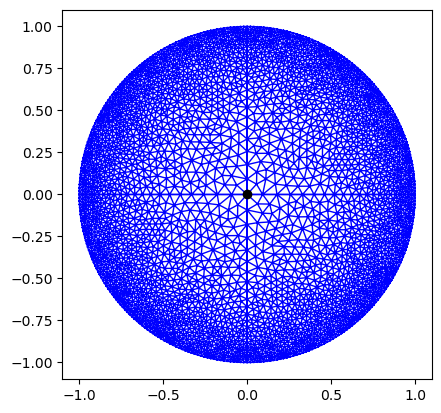

In [5]:
#%% mesh a circle with gmsh with a refinement in the center.

center_res = 0.1
out_res = 0.02
Lx_ext = 1.

coor,conn=mesh_circle(Lx_ext,center_res,out_res )

## plotting the unstructured mesh
import matplotlib
triang=matplotlib.tri.Triangulation(coor[:,0], coor[:,1], triangles=conn, mask=None)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'b-', lw=1)
ax1.plot(0.,0.,'ko')
plt.show()


In [6]:
kernel = "3DT0-H"
elas_prop = np.array([2*G*(1+nu), nu])
eta=3.0
max_leaf_size = 32
eps_aca = 1.0e-4

h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)
# checking that the mesh is properly ordered.... 
# mm=Mesh(coor.flatten(),conn.flatten(),kernel)
# all_norms =np.zeros((mm.num_elements(),3))
# for e in range(mm.num_elements()):
#     all_norms[e]=mm.get_element_normal(e)
# np.mean(all_norms[:,2]) 


NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 3DT0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.012954
 binary cluster tree depth =10
 Number of blocks =6220
 Number of full blocks =2520
 Number of low rank blocks =3700
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 2520 
Loop on low rank blocks construction
N low rank blocks 3700
dof_dimension: 3
Creation of hmat done in 10.4321
Compression ratio - 0.142294
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.142294, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  10.4322
BigWham constructed Hmat of size (7644 x 3) X (7644 x 3)


In [7]:
h.get_omp_threads()

NUM OF OMP THREADS used by BigWham: 

8

8


In [8]:
h.shape

(22932, 22932)

In [10]:
# uniform tensile loads
f = np.zeros(h.shape_[0])
f[2::3]=1

import time

### Estimate mat vect time
zt= time.process_time()
ze = time.time()
for i in range(20) :
    h.dot(f)
elapsed=(time.process_time()-zt)/20
print("matvect elapsed time",elapsed/8)
print("matvect elapsed time",(time.time()-ze)/20)

matvect elapsed time 0.03372118125000005
matvect elapsed time 0.03736975193023682


number of blocks 6220


/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python/bigwham4py.py:234: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


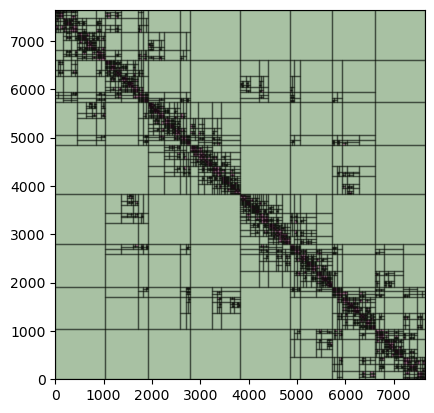

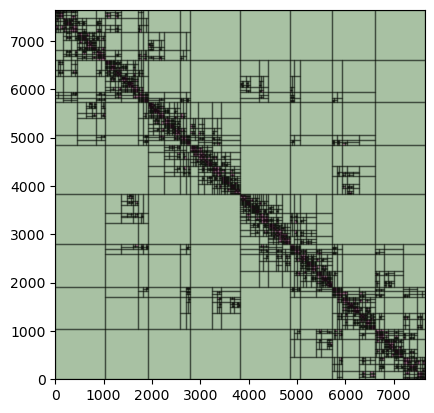

In [11]:
#h._getPattern()
h.plotPattern()

In [12]:

from scipy.sparse.linalg import gmres

jac_ilu= h.H_ILU_prec(drop_tol=1e-1,fill_factor=1) # we use a ILU decomposition of the full block for efficient solution via gmres


In [13]:
d = gmres(h,f,M=jac_ilu,rtol=1e-8)[0]
d_global=h.convert_to_global(d)

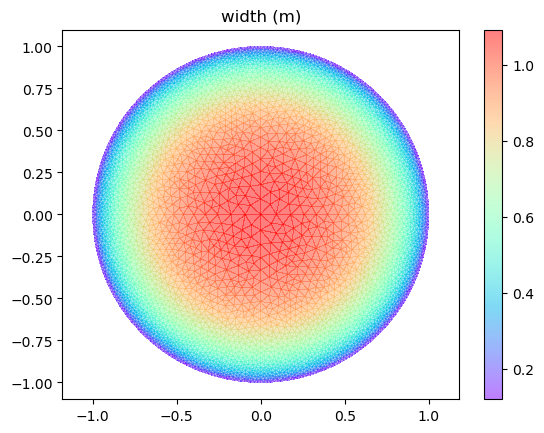

In [14]:

 
fig1, ax1 = plt.subplots()
tri=ax1.tripcolor(triang, d_global[2::3],cmap = plt.cm.rainbow, 
                    alpha = 0.5)
ax1.axis('equal')
plt.colorbar(tri) 
plt.title('width (m)')
plt.show()


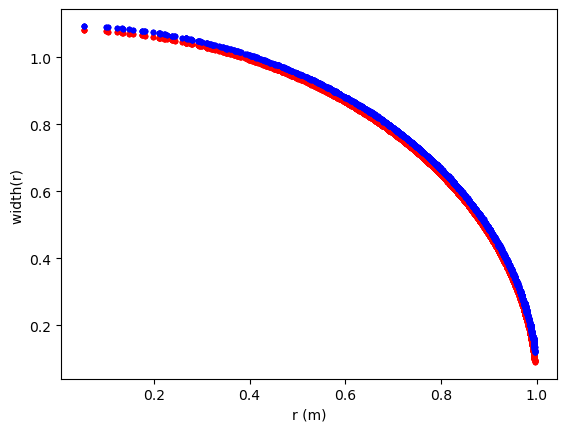

In [15]:
# collocation points - to compute analytical solutionm for width and then estimate stress & displacement at observations points
colpts=h.getCollocationPoints()
r_col = np.sqrt(colpts[:,0]**2+colpts[::,1]**2)
# Crack opening displacement discontinuity from analytical solution 
a=1
w = (4*(1-nu)/(G*np.pi))*np.sqrt(a**2-r_col**2)   

plt.plot(r_col,w,'.r')
plt.plot(r_col,d_global[2::3],'.b')
plt.xlabel('r (m)')
plt.ylabel('width(r) ')

abs_err =np.abs(w-d_global[2::3]) 
rel_err =np.abs(w-d_global[2::3])/w  

In [16]:
(w-d_global[2::3])/w

array([-0.05437139, -0.03209164, -0.01463607, ..., -0.02093678,
       -0.11406697, -0.01784645])

Text(0, 0.5, '$ | w_{num}-w_{true} |$ ')

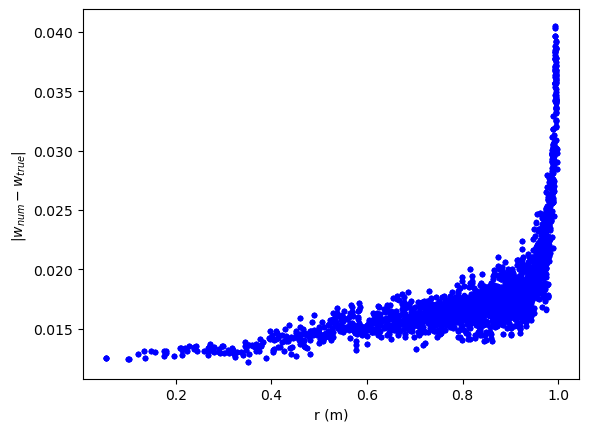

In [17]:
plt.plot(r_col,abs_err,'.b')
plt.xlabel('r (m)')
plt.ylabel('$ | w_{num}-w_{true} |$ ')


In [18]:
# L2 norm of the error     $\|| w_{true}(r_i)-w_{num}(r_i)\||_2  / \||  w_{true}(r_i)\|
np.linalg.norm(abs_err)/np.linalg.norm(w)

0.03180239801075677

Text(0, 0.5, '$| w_{num}-w_{true} | / w_{true}$ ')

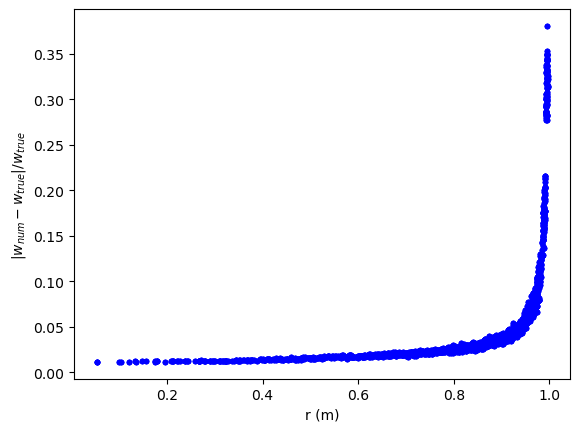

In [19]:
plt.plot(r_col,rel_err,'.b')
plt.xlabel('r (m)')
plt.ylabel('$| w_{num}-w_{true} | / w_{true}$ ')